In [1]:
import gym
from tqdm.notebook import tqdm
COLAB = False
if not COLAB:
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras import Input
from environment_ddpg import StockEnv, create_stock_env
from utils import ReplayBuffer, OrnsteinUhlenbeckActionNoise
path_base = "models/"
RESUME = True

In [2]:
class Actor:
    def __init__(self, params):
        self.output_range = params["output_range"]
        self.hidden_layers = params["actor_hidden_layers"]
        self.state_dimensions = params["state_dimensions"]
        self.action_dimensions = params["action_dimensions"]
        self.actor = self.model()
        
    def model(self):
        inputs = Input(shape=(1, self.state_dimensions))
        x = Lambda(lambda x: x)(inputs)
        for layer in self.hidden_layers:
            x = Dense(layer, activation='relu')(x)
        x = Dense(self.action_dimensions, activation='tanh')(x)
        x = Lambda(lambda x: x*self.output_range)(x)
        model = tf.keras.Model(inputs = inputs, outputs = x)
        return model
    
    def get_action(self, state):
        state_tensor = tf.Variable(shape = state.shape, initial_value = state)
        return (self.actor(state_tensor)).numpy()

    def save_weights(self):
        self.actor.save_weights(path_base + "actor.h5")
               
    def load_weights(self):
        self.actor.load_weights(path_base + "actor.h5")
        
    
class Critic:
    def __init__(self, params):
        self.hidden_layers = params["critic_hidden_layers"]
        self.state_dimensions = params["state_dimensions"]
        self.action_dimensions = params["action_dimensions"]
        self.optimizer = params["critic_optimizer"]
        self.critic_online = self.model()
        self.critic_target = self.model()


    def model(self):
        input_a = Input(shape = (1, self.state_dimensions))
        input_b = Input(shape = (1, self.action_dimensions))
        x = concatenate([input_a, input_b], axis=-1)
        for layer in self.hidden_layers:
            x = Dense(layer, activation='relu')(x)
        x = Dense(1, activation='linear')(x)
        model = tf.keras.Model(inputs=[input_a, input_b], outputs = x)
        model.compile(loss='mse', optimizer=self.optimizer)
        return model
    
    def save_weights(self):
        self.critic_online.save_weights(path_base + "critic_online.h5")
        self.critic_target.save_weights(path_base +  "critic_target.h5")
               
    def load_weights(self):
        self.critic_online.load_weights(path_base + "critic_online.h5")
        self.critic_target.load_weights(path_base + "critic_target.h5")

    def get_qvalues(self, state_array, action_array, online=True):
        state_tensor = tf.Variable(shape = state_array.shape, initial_value = state_array)
        action_tensor = tf.Variable(shape = action_array.shape, initial_value = action_array)
        return (self.critic_online([state_tensor, action_tensor]).numpy() if online else self.critic_target([state_tensor, action_tensor]).numpy())
    
    def call(self, state_tensor, action_tensor, online = True):
        return (self.critic_online([state_tensor, action_tensor]) if online else self.critic_target([state_tensor, action_tensor]))
    def merge_networks(self, tau):
        self.critic_target.set_weights(tau*np.array(self.critic_online.get_weights())
                                                                    + (1-tau)*np.array(self.critic_target.get_weights()))
        
    

In [3]:
class Agent:
    def __init__(self, params, test=False):
        self.test = test
        self.actor = Actor(params)
        self.critic = Critic(params)
        self.buffer = ReplayBuffer(params["buffer_size"])
        self.state_dimensions = params["state_dimensions"]
        self.action_dimensions = params["action_dimensions"]
        self.discount = params["discount"]
        self.action_range = params["output_range"]
        self.save_frequency = params["save_frequency"]
        self.batch_size = params["batch_size"]
        self.optimizer = params["actor_optimizer"]
        self.tau = params["tau"]
        self.step = 0
        self.noise_func =  OrnsteinUhlenbeckActionNoise(mu=np.zeros(params["action_dimensions"]))
        if RESUME:
            self.load_networks()
        
    def agent_start(self, observation):
        observation = np.reshape(observation, (1, self.state_dimensions))
        act = np.squeeze(self.actor.get_action(observation))
        if not self.test:
            action = self.clip_action(act + self.noise_func())
        else:
            action = [self.clip_action(act)]
        self.prev_state = observation
        self.prev_action = action
        return action 

    def clip_action(self, action):
        if abs(action) > self.action_range:
            action *= abs(self.action_range)/abs(action)
        
        return action

    def agent_step(self, reward, observation):
        observation = np.reshape(observation, (1, self.state_dimensions))
        if not self.test:
            relay = (self.prev_state, self.prev_action, reward, observation)
            self.buffer.add(relay)
        self.prev_state = observation
        act = np.squeeze(self.actor.get_action(observation))
        if not self.test:
            self.prev_action = self.clip_action(act + self.noise_func())
            self.train(self.batch_size)
        else:
            self.prev_action = [self.clip_action(act)]
        
        return self.prev_action 
    
    def save_networks(self):
        self.actor.save_weights()
        self.critic.save_weights()

    def load_networks(self):
        self.actor.load_weights()
        self.critic.load_weights()


    def train(self, sample_size):
        self.step += 1
        batch, batch_size = self.buffer.sample(sample_size)

        state_array = np.array([ element[3] for element in batch])
        action_array = self.actor.get_action(state_array)
        prev_state_array = np.array([ element[0] for element in batch])
        prev_action_array = np.array([ [[element[2]]] for element in batch])
        output = self.critic.get_qvalues(state_array, action_array, False)
        output = np.array([element[2] + self.discount*out[0] for element, out in zip(batch, output)])
        self.critic.critic_online.fit([state_array, action_array], output, verbose=0)

        prev_state_tensor = tf.Variable(shape = prev_state_array.shape, initial_value = prev_state_array)
        prev_action_tensor = tf.Variable(shape = prev_action_array.shape, initial_value = prev_action_array)

        with tf.GradientTape(persistent=True) as g:
            g.watch(prev_action_tensor) 
            g.watch(prev_state_tensor)
            value = self.critic.call(prev_state_tensor, prev_action_tensor)
            action = self.actor.actor(prev_state_tensor)
            
        gradient = -tf.squeeze(g.gradient(value, prev_action_tensor))
        gradient = tf.cast(gradient, tf.float32)
        gradient_actor = g.gradient(action, self.actor.actor.trainable_weights, gradient)
        gradient_actor = list(map(lambda x: tf.math.divide(x, batch_size), gradient_actor))
        self.optimizer.apply_gradients(zip(gradient_actor, self.actor.actor.trainable_weights))
        self.critic.merge_networks(self.tau)

        if self.step%self.save_frequency == 0:
            self.save_networks()



In [4]:
AGENT_PARAMS = {
	"output_range": 1,
	"actor_hidden_layers": [30, 8],
	"critic_hidden_layers": [30, 8],
	"state_dimensions": 4,
	"action_dimensions": 1,
	"critic_optimizer": tf.keras.optimizers.Adam(learning_rate = 0.001),
	"actor_optimizer": tf.keras.optimizers.Adam(learning_rate = 0.0001),
	"batch_size": 64,
	"buffer_size":1000000,
	"discount": 0.99,
	"tau": 0.001,
	"save_frequency": 100
}


In [6]:
## Train LOOP
agent = Agent(AGENT_PARAMS)
env, ITERATIONS = create_stock_env("data/AAPL.csv")
ITERATIONS = 20000
pbar = tqdm(desc="Iteration: ", total=ITERATIONS)
action = agent.agent_start(env.reset())
observation, reward, done, info = env.step(action[0])
profit = np.zeros(ITERATIONS)
prev_profit = 0
for _ in range(ITERATIONS):
    action = agent.agent_step(reward, observation)
    observation, reward, done, info = env.step(action[0])
    profit[i] += reward + prev_profit
    prev_profit += reward
    pbar.update(1)

FileNotFoundError: [Errno 2] File b'd' does not exist: b'd'

At FGB.csv
False
0
False
0


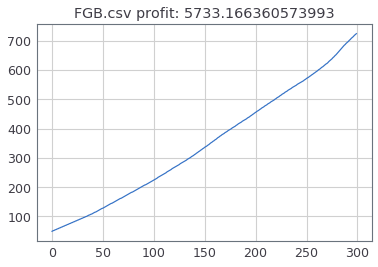

At FDS.csv
False
0
False
0


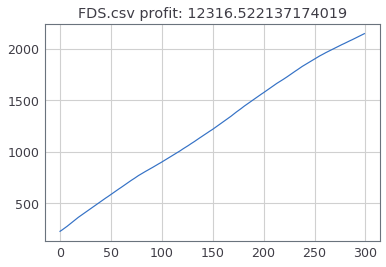

At FLL.csv
False
0
False
0


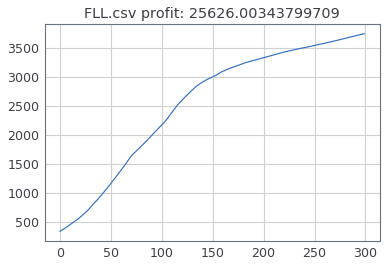

At FNJN.csv
False
0
False
0


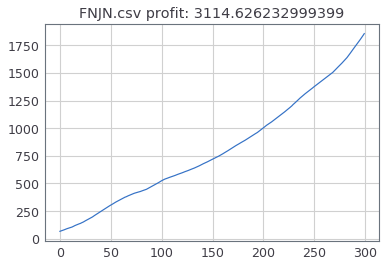

At FHB.csv
False
0
False
0


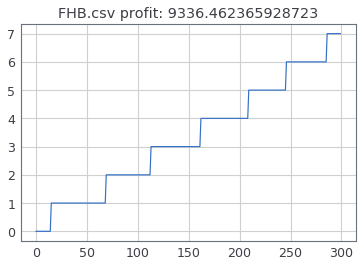

At FET.csv
False
0
False
0


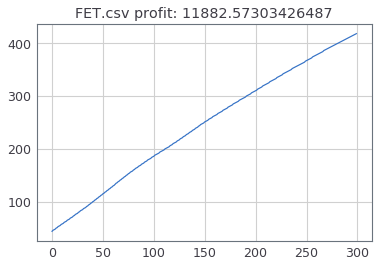

At FNKO.csv
False
0
False
0


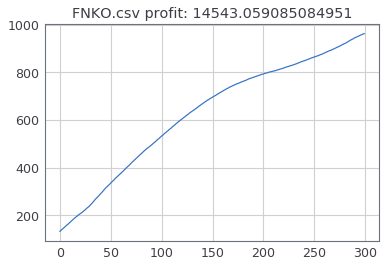

At FIV.csv
False
0
False
0


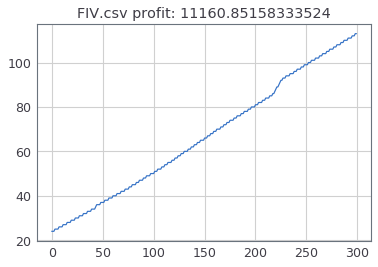

At FFBC.csv
False
0
False
0


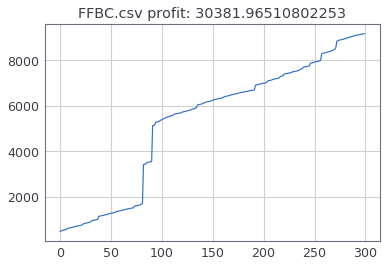

At FIT.csv
False
0
False
0


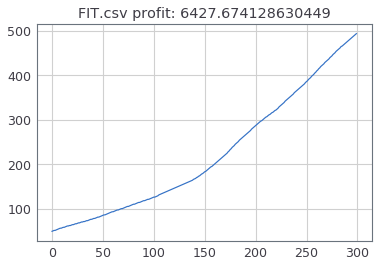

At FHI.csv
False
0
False
0


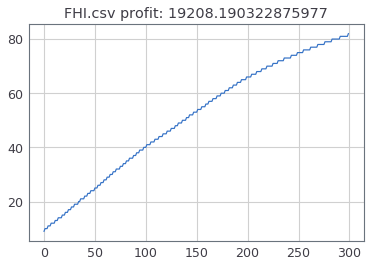

At FLDM.csv
False
0
False
0


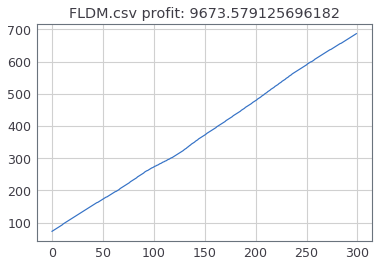

At ACHV.csv
False
0
False
0


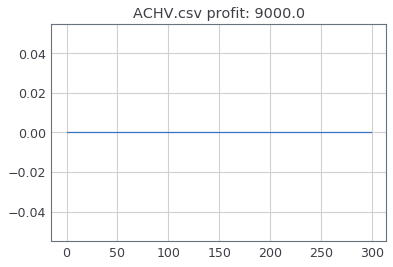

At FFBW.csv
False
0
False
0


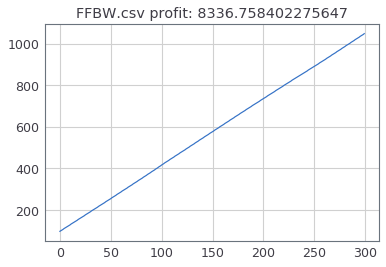

At MSFT.csv
False
0
False
0


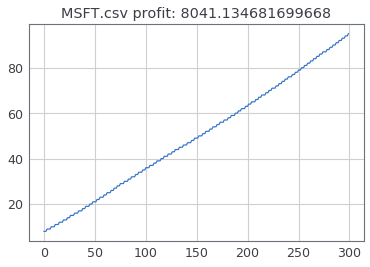

At FLEX.csv
False
0
False
0


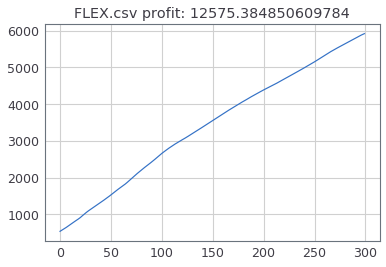

At FEUL.csv
False
0
False
0


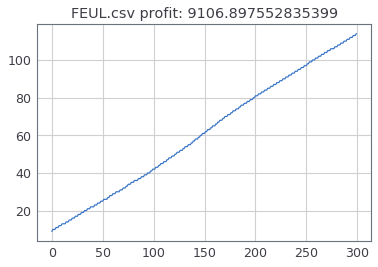

At FIVE.csv
False
0
False
0


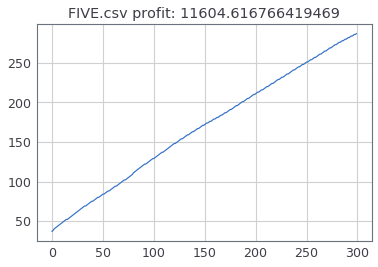

At FLC.csv
False
0
False
0


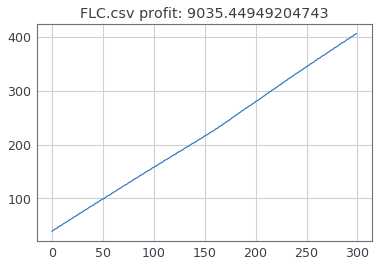

At FISI.csv
False
0
False
0


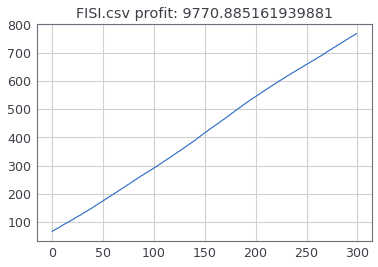

At FENG.csv
False
0
False
0


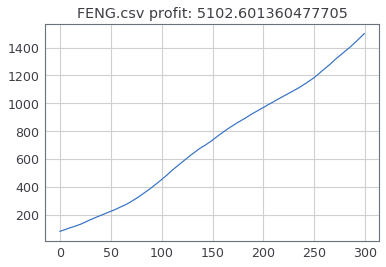

At FNGO.csv
False
0
False
0


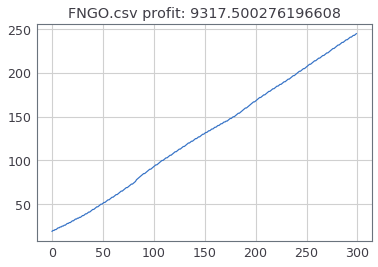

At FMCI.csv
False
0
False
0


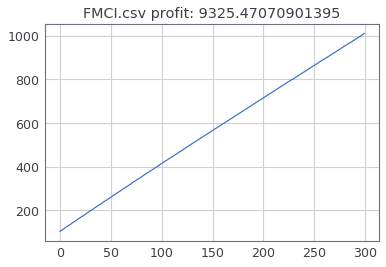

At FEYE.csv
False
0
False
0


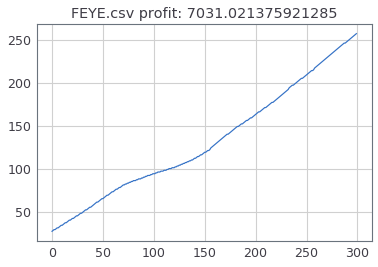

At FMC.csv
False
0
False
0


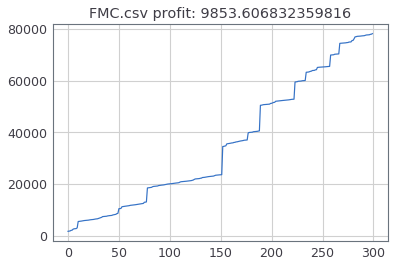

At FFC.csv
False
0
False
0


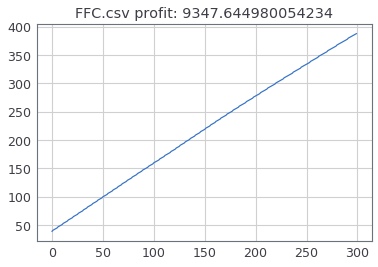

At FLIR.csv
False
0
False
0


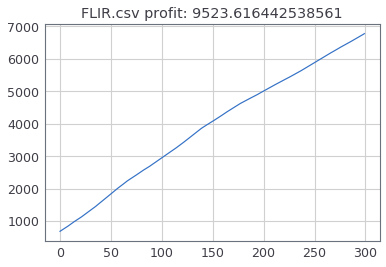

At FF.csv
False
0
False
0


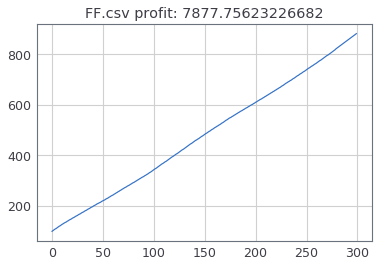

At FEO.csv
False
0
False
0


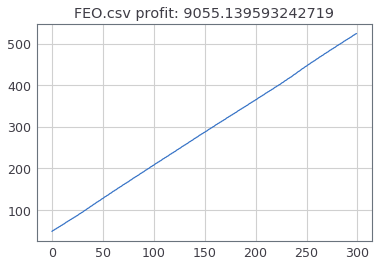

At FITB.csv
False
0
False
0


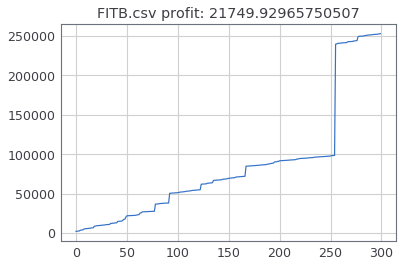

At FDEF.csv
False
0
False
0


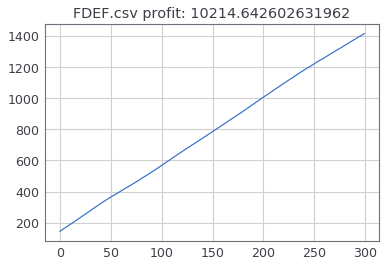

At FLXS.csv
False
0
False
0


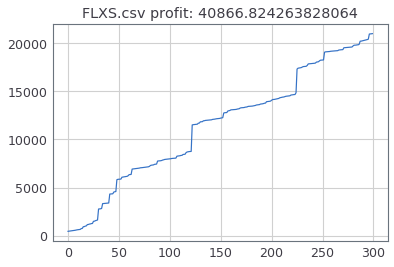

At ACH.csv
False
0
False
0


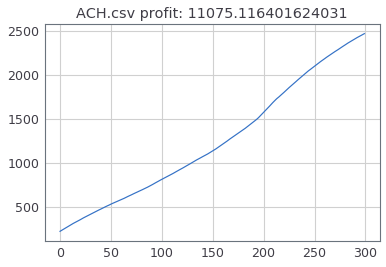

At FLXN.csv
False
0
False
0


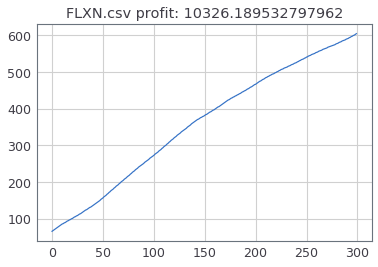

At ACGLO.csv
False
0
False
0


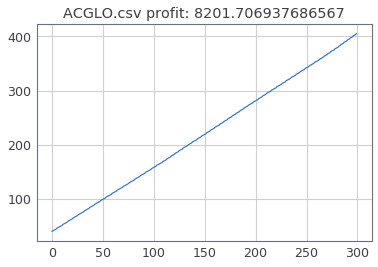

At FISV.csv
False
0
False
0


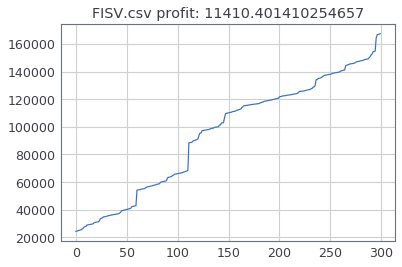

At FITBO.csv
False
0
False
0


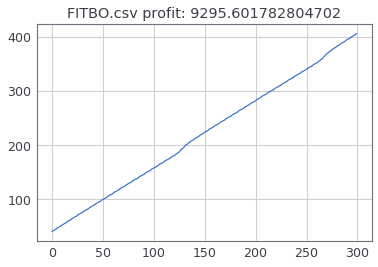

At FLIC.csv
False
0
False
0


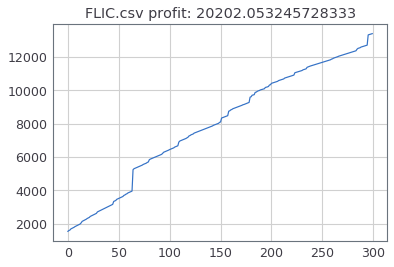

At FDBC.csv
False
0
False
0


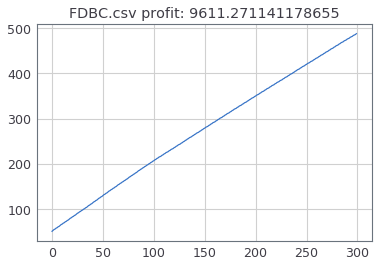

At FND.csv
False
0
False
0


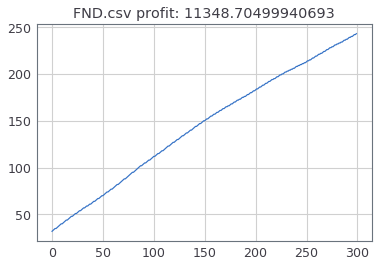

At FG.csv
False
0
False
0


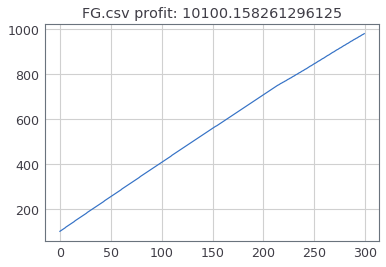

At ACIU.csv
False
0
False
0


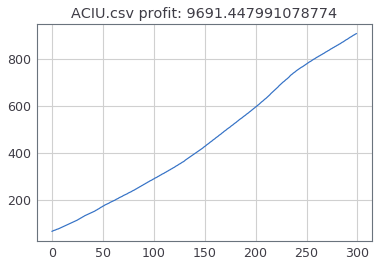

At FLGT.csv
False
0
False
0


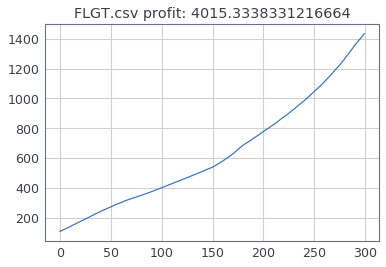

At FDEU.csv
False
0
False
0


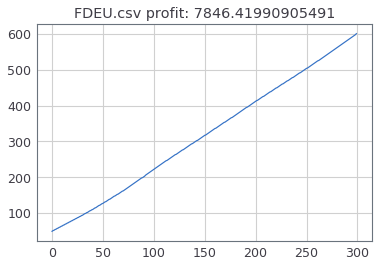

At FMAO.csv
False
0
False
0


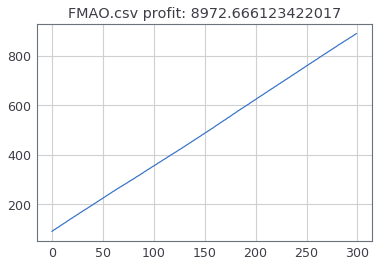

At FLAT.csv
False
0
False
0


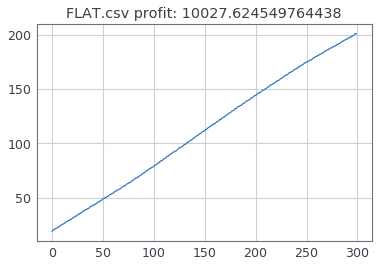

At FMBI.csv
False
0
False
0


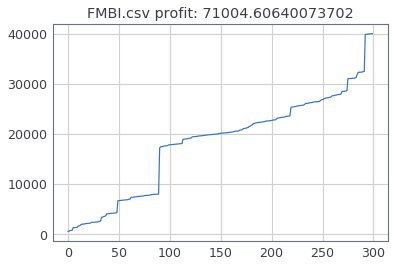

At FFA.csv
False
0
False
0


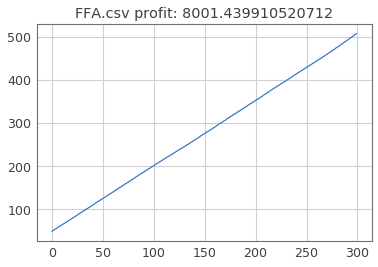

At FLMN.csv
False
0
False
0


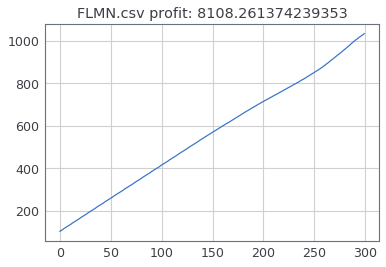

At FLNG.csv
False
0
False
0


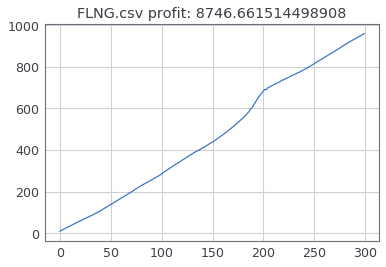

At FCX.csv
False
0
False
0


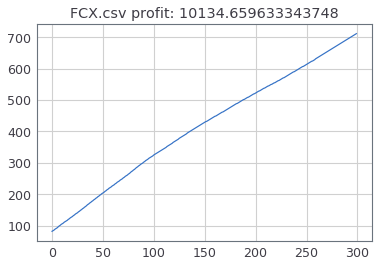

At FMBH.csv
False
0
False
0


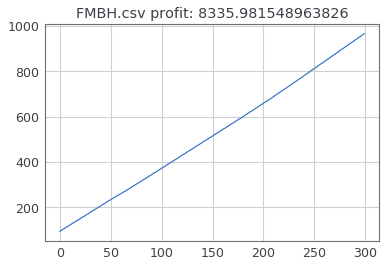

At FDUSG.csv
False
0
False
0


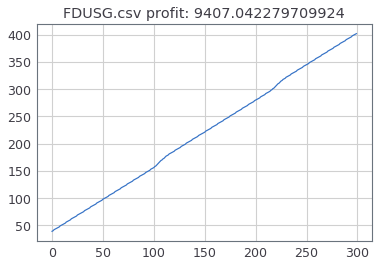

At FNF.csv
False
0
False
0


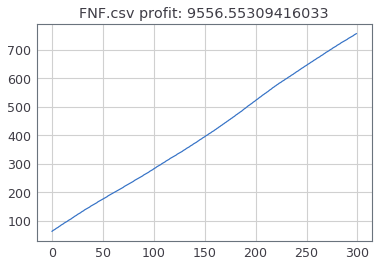

At FHN.csv
False
0
False
0


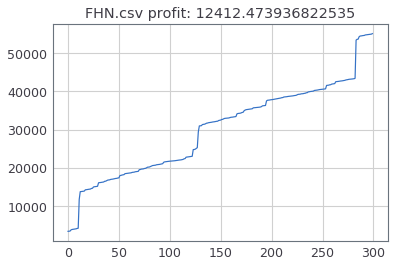

At FLWS.csv
False
0
False
0


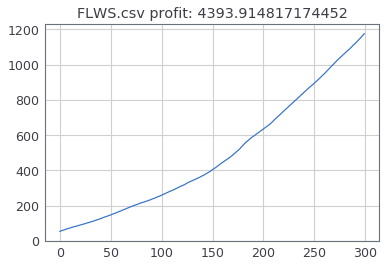

At FNCB.csv
False
0
False
0


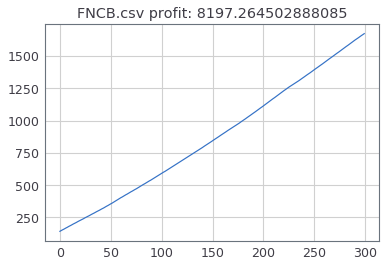

At FDUSZ.csv
False
0
False
0


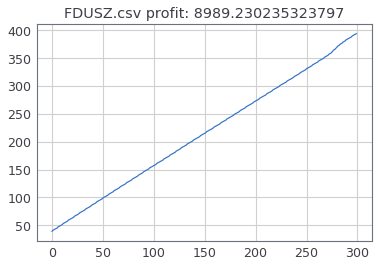

At FDX.csv
False
0
False
0


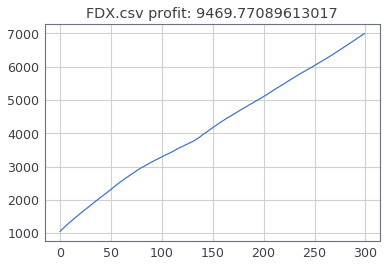

At FITBP.csv
False
0
False
0


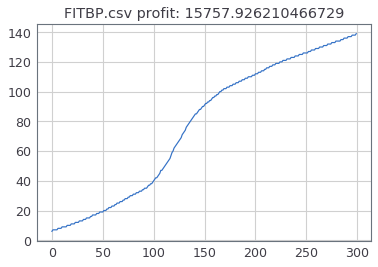

At ACIA.csv
False
0
False
0


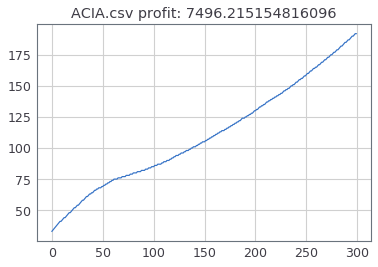

At FDP.csv
False
0
False
0


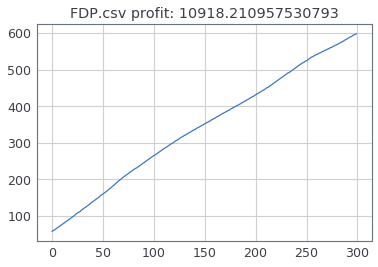

At FI.csv
False
0
False
0


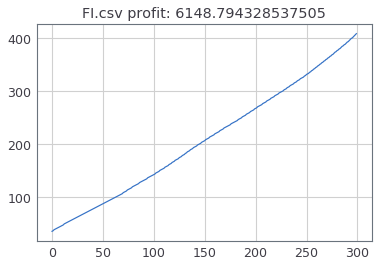

At FLY.csv
False
0
False
0


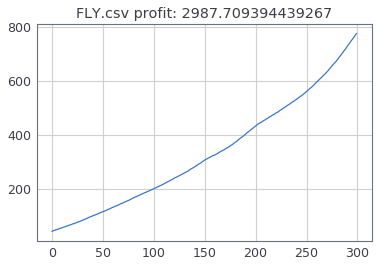

At FDUS.csv
False
0
False
0


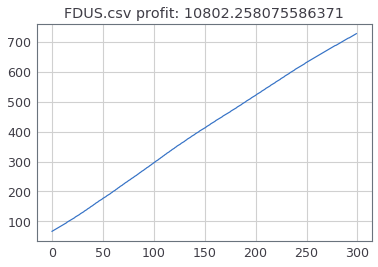

At ACGL.csv
False
0
False
0


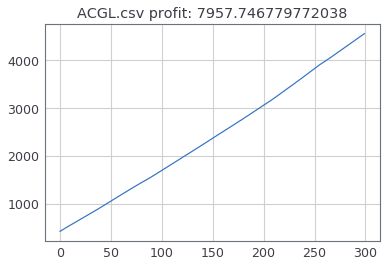

At FNGU.csv
False
0
False
0


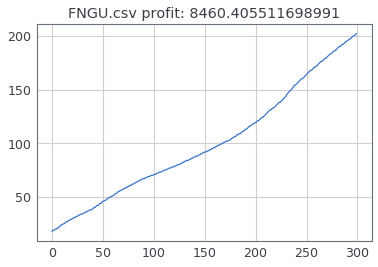

At FNGD.csv
False
0
False
0


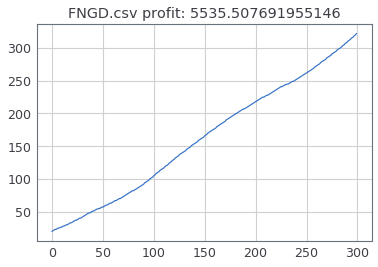

At AAPL.csv
False
0
False
0


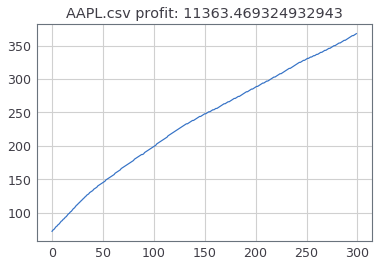

At FNHC.csv
False
0
False
0


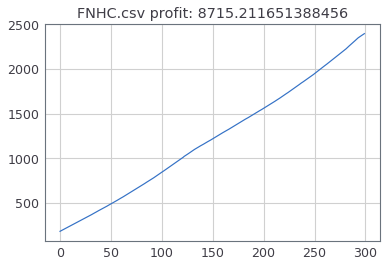

At FLGE.csv
False
0
False
0


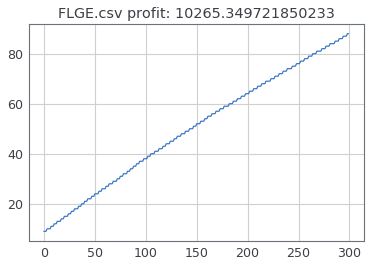

At FITBI.csv
False
0
False
0


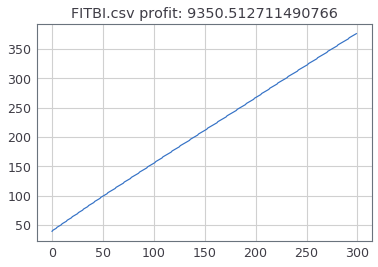

At FENC.csv
False
0
False
0


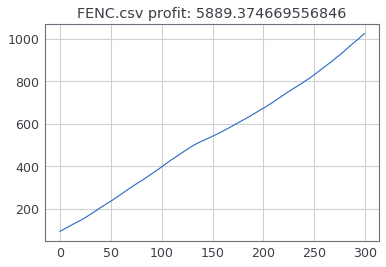

At FMN.csv
False
0
False
0


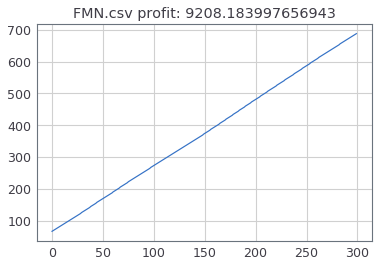

At ACHC.csv
False
0
False
0


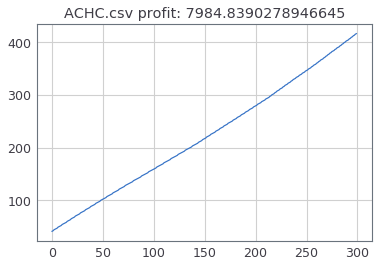

At FIBK.csv
False
0
False
0


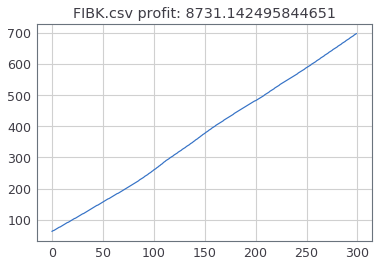

At FNGZ.csv
False
0
False
0


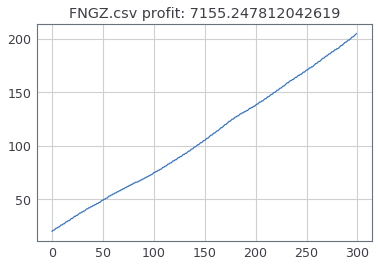

At FGBI.csv
False
0
False
0


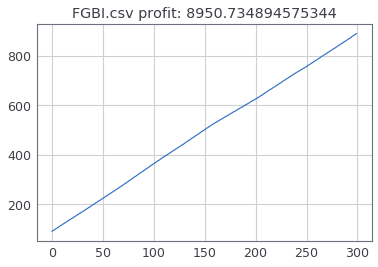

At ACGLP.csv
False
0
False
0


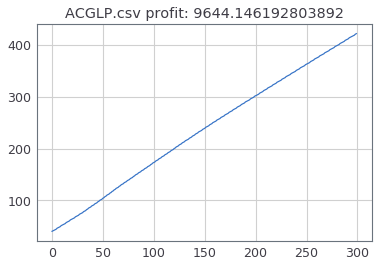

At FFWM.csv
False
0
False
0


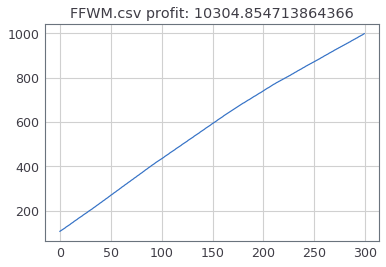

At FMCIU.csv
False
0
False
0


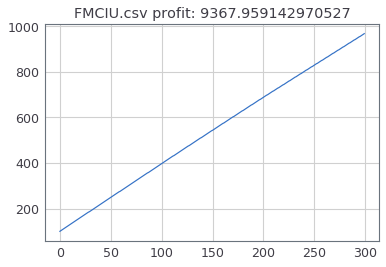

At FISK.csv
False
0
False
0


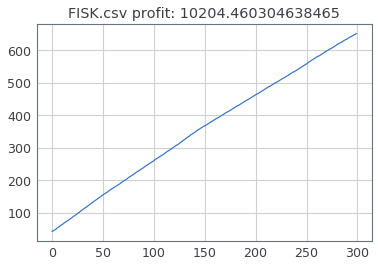

At FGEN.csv
False
0
False
0


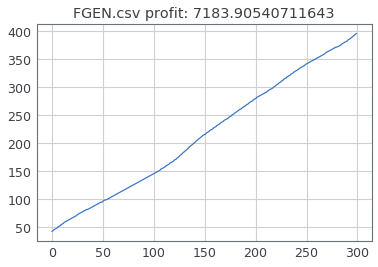

In [17]:
## TEST LOOP
agent = Agent(AGENT_PARAMS, test=True)
import matplotlib.pyplot as plt
import os
files = os.listdir("data/")
final_profit_dict = {}
for num_iter, file in enumerate(files):
    print ("At " + file)
    env, ITERATIONS = create_stock_env("data/{0}".format(file), False)
    ITERATIONS = 300
    profit = np.zeros(ITERATIONS)
    shares = np.zeros(ITERATIONS)
    prev_profit = 0 
    obs = env.reset()
    prev_profit = 0
    action = agent.agent_start(env.reset())
    observation, reward, done, info = env.step(action[0])
    pbar = tqdm(desc="Iteration: ", total=ITERATIONS)
    for i in range(ITERATIONS):
        action = agent.agent_step(reward, observation)
        observation, reward, done, info = env.step(action[0])
        profit[i] += reward + prev_profit
        shares[i] = info["shares_held"]
        prev_profit +=reward
        pbar.update(1)
    plt.figure() 
    plt.plot(shares)
    
    plt.title(file + " profit: "+str(profit[-1]))
    plt.show()
    final_profit_dict[file] = profit[-1]
    